# 1. Examine and Clean
This notebook contains the process used to import, examine, and clean the dataset containing COVID hospital cases by county. It also includes the process used to slim down the US gov's USA county shapefiles to only include the contiguous US states.

### 1.0.1 Import Packages

In [105]:
import numpy as np #linear algebra
import pandas as pd #data processing, CSV file I/O
import matplotlib.pyplot as plt
import seaborn as sns

# Import libraries for reading geographic data
import geopandas as gpd
from shapely.geometry import Point, shape
import requests
import zipfile
import io
import os

%matplotlib inline

In [106]:
os.getcwd()

'/Users/tiffanyflor/Dropbox/MyProjects/usacovidhosp/notebooks'

In [107]:
# List files in the raw data directory

for dirname, _, filenames in os.walk('../data/raw/'):
    for filename in filenames:
        print(filename)

tl_2017_us_county.cpg
tl_2017_us_county.shp
Merged_Final.csv
tl_2017_us_county.shx
.gitkeep
tl_2017_us_county.dbf
tl_2017_us_county.prj


### 1.1.1 Import and Examine COVID Hospital Data
Import dataset as a pandas DataFrame. Examine metadata and univariate descriptive statistics.

In [108]:
# Merged_Final.csv --> contains USA hospitals with COVID by county
# Put into dataframe
df = pd.read_csv('../data/raw/Merged_Final.csv')

In [109]:
# View data
df.head()

,County Name,Facility_Name,Full_Address,State,Total,latitudes,longitudes
0,HOUSTON,SOUTHEAST ALABAMA MEDICAL CENTER,"1108 ROSS CLARK CIRCLE,DOTHAN,HOUSTON,AL",AL,2427,31.215827,-85.363433
1,MARSHALL,MARSHALL MEDICAL CENTERS,"2505 U S HIGHWAY 431 NORTH,BOAZ,MARSHALL,AL",AL,5104,34.601233,-87.123343
2,LAUDERDALE,NORTH ALABAMA MEDICAL CENTER,"1701 VETERANS DRIVE,FLORENCE,LAUDERDALE,AL",AL,2120,34.805043,-87.650814
3,JEFFERSON,ST. VINCENT'S EAST,"50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,JEFFERSO...",AL,26142,33.564772,-86.760155
4,SHELBY,SHELBY BAPTIST MEDICAL CENTER,"1000 FIRST STREET NORTH,ALABASTER,SHELBY,AL",AL,20720,33.075378,-86.519100


In [110]:
# Get rows and columns
df.shape

(4478, 7)

In [111]:
# List data types and counts
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4478 entries, 0 to 4477
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   County Name    4478 non-null   object 
 1   Facility_Name  4478 non-null   object 
 2   Full_Address   4478 non-null   object 
 3   State          4478 non-null   object 
 4   Total          4478 non-null   int64  
 5   latitudes      4478 non-null   float64
 6   longitudes     4478 non-null   float64
dtypes: float64(2), int64(1), object(4)
memory usage: 245.0+ KB


In [112]:
# Summary statistics for numerical columns
df.describe(include=[np.number])

,Total,latitudes,longitudes
count,4478.000000,4478.000000,4478.000000
mean,13635.779812,37.942630,-93.095641
std,27010.816470,5.383805,14.995810
min,0.000000,18.372500,-159.671259
25%,497.000000,34.001714,-99.310467
50%,3581.000000,38.773624,-90.291356
75%,14835.000000,41.682943,-82.382111
max,159045.000000,58.329259,-66.046000


In [113]:
# Summary statistics for object and categorical columns
df.describe(include=[np.object, pd.Categorical])

,County Name,Facility_Name,Full_Address,State
count,4478,4478,4478,4478
unique,1273,4341,4476,51
top,LOS ANGELES,MEMORIAL HOSPITAL,"47 SOUTH FOURTH ST,ROLLING FORK,SHARKEY,MS",TX
freq,90,12,2,407


### 1.1.2 Clean Hospital Data
Drop unnecessary rows and remove duplicates. Reset index for a clean dataframe.

In [114]:
# Check out the number of states listed
df['State'].nunique()

51

In [115]:
# Notice it includes Puerto Rico
df['State'].unique()

array(['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI',
       'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI',
       'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC',
       'ND', 'OH', 'OK', 'OR', 'PA', 'PR', 'RI', 'SC', 'SD', 'TN', 'TX',
       'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY'], dtype=object)

In [116]:
# Since we are only concerned with the 50 US states, we'll drop rows containing PR
df = df[df.State != 'PR']
df.shape

(4460, 7)

In [117]:
# Check for duplicate hospitals
df['Full_Address'].value_counts()

101 CIRCLE DRIVE,HILLSBORO,HILL,TX                 2
47 SOUTH FOURTH ST,ROLLING FORK,SHARKEY,MS         2
1500 S MAIN ST,FORT WORTH,TARRANT,TX               1
751 NE BLAKELY DR,ISSAQUAH,KING,WA                 1
3001 BROADMOOR BLVD NE,RIO RANCHO,SANDOVAL,NM      1
                                                  ..
172 KINSLEY ST,NASHUA,HILLSBOROUGH,NH              1
501 NORTH LANSDOWNE AVE,DREXEL HILL,DELAWARE,PA    1
1501 SOUTH DIXIE STREET,HORSE CAVE,HART,KY         1
41 EAST POST R0AD,WHITE PLAINS,WESTCHESTER,NY      1
9191 GRANT ST,THORNTON,ADAMS,CO                    1
Name: Full_Address, Length: 4458, dtype: int64

In [118]:
# Examine hospitals with more than one listing
df[df['Full_Address'] == '47 SOUTH FOURTH ST,ROLLING FORK,SHARKEY,MS']

,County Name,Facility_Name,Full_Address,State,Total,latitudes,longitudes
2158,SHARKEY,SHARKEY ISSAQUENA COMMUNITY HOSPITAL,"47 SOUTH FOURTH ST,ROLLING FORK,SHARKEY,MS",MS,65,34.004727,-90.070306
2212,SHARKEY,SHARKEY ISSAQUENA COMMUNITY HOSPITAL,"47 SOUTH FOURTH ST,ROLLING FORK,SHARKEY,MS",MS,65,34.004727,-90.070306


In [119]:
df[df['Full_Address'] == '101 CIRCLE DRIVE,HILLSBORO,HILL,TX']

,County Name,Facility_Name,Full_Address,State,Total,latitudes,longitudes
3725,HILL,HILL REGIONAL HOSPITAL,"101 CIRCLE DRIVE,HILLSBORO,HILL,TX",TX,239,31.269893,-98.943568
3947,HILL,HILL REGIONAL HOSPITAL,"101 CIRCLE DRIVE,HILLSBORO,HILL,TX",TX,239,31.269893,-98.943568


In [120]:
# Review areas around index to determine if there is an obvious order to hospital input
df.iloc[2155:2163]

,County Name,Facility_Name,Full_Address,State,Total,latitudes,longitudes
2155,HINDS,MERIT HEALTH CENTRAL,"1850 CHADWICK DR,JACKSON,HINDS,MS",MS,3691,32.287775,-90.254940
2156,WAYNE,WAYNE GENERAL HOSPITAL,"950 MATTHEW DR,WAYNESBORO,WAYNE,MS",MS,29753,31.673138,-88.634152
2157,FORREST,FORREST GENERAL HOSPITAL,"6051 US HIGHWAY 49,HATTIESBURG,FORREST,MS",MS,1197,33.079453,-89.858575
2158,SHARKEY,SHARKEY ISSAQUENA COMMUNITY HOSPITAL,"47 SOUTH FOURTH ST,ROLLING FORK,SHARKEY,MS",MS,65,34.004727,-90.070306
2159,LAUDERDALE,ANDERSON REGIONAL MEDICAL CENTER SOUTH CAMPUS,"1102 CONSTITUTION AVENUE,MERIDIAN,LAUDERDALE,MS",MS,2120,31.686577,-88.652958
2160,WASHINGTON,DELTA REGIONAL MEDICAL CENTER,"1400 E UNION ST,GREENVILLE,WASHINGTON,MS",MS,17929,33.410527,-91.035356
2161,ADAMS,MERIT HEALTH NATCHEZ,"52 SERGEANT PRENTISS DRIVE,NATCHEZ,ADAMS,MS",MS,7059,31.867069,-90.443150
2162,MARION,MARION GENERAL HOSPITAL,"1560 SUMRALL RD,COLUMBIA,MARION,MS",MS,22462,31.255953,-89.805607


In [121]:
# No obvious pattern found
# Drop 2nd occurence of each duplicate
df.drop([2212,3947], inplace=True)

In [122]:
# Check rows have been dropped
df.loc[2211:2213]

,County Name,Facility_Name,Full_Address,State,Total,latitudes,longitudes
2211,TIPPAH,TIPPAH COUNTY HOSPITAL,"1005 CITY AVE NORTH,RIPLEY,TIPPAH,MS",MS,193,34.739039,-88.950607
2213,RANKIN,BRENTWOOD BEHAVIORAL HEALTHCARE OF MS,"3531 EAST LAKELAND DRIVE,FLOWOOD,RANKIN,MS",MS,1459,32.357990,-90.011870


In [123]:
df.loc[3945:3948]
# Notice that the index and iloc do not match anymore so we had to use loc
# and now have to reset index

,County Name,Facility_Name,Full_Address,State,Total,latitudes,longitudes
3945,HAMILTON,HAMILTON GENERAL HOSPITAL,"400 N BROWN, BUILDING 1,HAMILTON,HAMILTON,TX",TX,15125,31.703875,-98.113448
3946,HOUSTON,CROCKETT MEDICAL CENTER,"1100 E LOOP 304,CROCKETT,HOUSTON,TX",TX,2427,31.322152,-95.437114
3948,TARRANT,COOK CHILDRENS MEDICAL CENTER,"801 SEVENTH AVENUE,FORT WORTH,TARRANT,TX",TX,21617,30.851827,-95.187186


In [124]:
# Reset index
df.reset_index(drop=True, inplace=True)

# Check index has been reset
df.iloc[3945:3948]

,County Name,Facility_Name,Full_Address,State,Total,latitudes,longitudes
3945,KERR,KERRVILLE STATE HOSP,"721 THOMPSON DR,KERRVILLE,KERR,TX",TX,255,30.045887,-99.157744
3946,WICHITA,RED RIVER HOSPITAL,"1505 8TH ST,WICHITA FALLS,WICHITA,TX",TX,709,33.906316,-98.501335
3947,HARRIS,WEST OAKS HOSPITAL,"6500 HORNWOOD,HOUSTON,HARRIS,TX",TX,56280,29.708962,-95.496980


### 1.1.3 Reduce Memory Usage of Hospital Data
Change data types of columns

In [125]:
# Inspect the data types of each column
df.dtypes

County Name       object
Facility_Name     object
Full_Address      object
State             object
Total              int64
latitudes        float64
longitudes       float64
dtype: object

In [126]:
# Find memory usage of each column
original_mem = df.memory_usage(deep=True)
original_mem

Index               128
County Name      286237
Facility_Name    381694
Full_Address     432295
State            263022
Total             35664
latitudes         35664
longitudes        35664
dtype: int64

In [127]:
# We know from our examination above that State only has 50 unique values
# It can be changed to a categorical variable
# Can anything else? Find the percentage of unique values in each category
df.select_dtypes(include=['object']).nunique()/df.select_dtypes(include=['object']).count()

County Name      0.285554
Facility_Name    0.969717
Full_Address     1.000000
State            0.011216
dtype: float64

In [128]:
# We see that County Name has about 29% unique values,
# Facility has 97%, Full_Address has 100%, and State has 1%
# The best candidate for categorical is the State column
df['State'] = df['State'].astype('category')
df.dtypes

County Name        object
Facility_Name      object
Full_Address       object
State            category
Total               int64
latitudes         float64
longitudes        float64
dtype: object

In [130]:
# Let's try out County Name to see if it's worth it
df['County Name'] = df['County Name'].astype('category')
df.dtypes

County Name      category
Facility_Name      object
Full_Address       object
State            category
Total               int64
latitudes         float64
longitudes        float64
dtype: object

In [131]:
# compute new memory usage
new_mem = df.memory_usage(deep=True)
new_mem

Index               128
County Name      131453
Facility_Name    381694
Full_Address     432295
State              9968
Total             35664
latitudes         35664
longitudes        35664
dtype: int64

In [132]:
# Compare original with updated memory usage
new_mem/original_mem

Index            1.000000
County Name      0.459245
Facility_Name    1.000000
Full_Address     1.000000
State            0.037898
Total            1.000000
latitudes        1.000000
longitudes       1.000000
dtype: float64

State has shrunk to 3.8% of it's original size.<br>
County Name has shrunk to 46% of it's original size

### 1.3.1 Import and Examine USA County Shapefile
Class Codes and Definitions For Reference<br>
https://www.census.gov/library/reference/code-lists/class-codes.html#:~:text=The%20class%20(CLASSFP)%20code%20defines,gazetteer%20files%2C%20and%20other%20products.

In [166]:
# List files in the raw data directory

for dirname, _, filenames in os.walk('../data/raw/'):
    for filename in filenames:
        print(filename)

tl_2017_us_county.cpg
tl_2017_us_county.shp
Merged_Final.csv
tl_2017_us_county.shx
.gitkeep
tl_2017_us_county.dbf
tl_2017_us_county.prj


In [167]:
raw_path = '../data/raw/'

dbf = 'tl_2017_us_county.dbf'
prj = 'tl_2017_us_county.prj'
shp = 'tl_2017_us_county.shp'
shx = 'tl_2017_us_county.shx'

usa_counties = gpd.read_file(raw_path + shp)
print('Shape of dataframe: {}'.format(usa_counties.shape))
print('Projection of dataframe: {}'.format(usa_counties.crs))
usa_counties.tail()

Shape of dataframe: (3233, 18)
Projection of dataframe: epsg:4269


,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
3228,13,123,00351260,13123,Gilmer,Gilmer County,06,H1,G4020,None,None,None,A,1103942496,12227724,+34.6905055,-084.4546244,"POLYGON ((-84.65478 34.66559, -84.65488 34.669..."
3229,27,135,00659513,27135,Roseau,Roseau County,06,H1,G4020,None,None,None,A,4329471930,16913419,+48.7610683,-095.8215042,"POLYGON ((-96.40466 48.80528, -96.40467 48.813..."
3230,28,089,00695768,28089,Madison,Madison County,06,H1,G4020,298,27140,None,A,1850209209,71667634,+32.6343703,-090.0341603,"POLYGON ((-90.09363 32.70763, -90.09360 32.707..."
3231,48,227,01383899,48227,Howard,Howard County,06,H1,G4020,None,13700,None,A,2333039139,8841781,+32.3034712,-101.4387720,"POLYGON ((-101.69227 32.27106, -101.69221 32.2..."
3232,54,099,01550056,54099,Wayne,Wayne County,06,H1,G4020,170,26580,None,A,1310504124,15860720,+38.1455413,-082.4196812,"POLYGON ((-82.59529 38.36978, -82.59515 38.369..."


In [168]:
# Examine information about dataframe
usa_counties.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3233 entries, 0 to 3232
Data columns (total 18 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   STATEFP   3233 non-null   object  
 1   COUNTYFP  3233 non-null   object  
 2   COUNTYNS  3233 non-null   object  
 3   GEOID     3233 non-null   object  
 4   NAME      3233 non-null   object  
 5   NAMELSAD  3233 non-null   object  
 6   LSAD      3233 non-null   object  
 7   CLASSFP   3233 non-null   object  
 8   MTFCC     3233 non-null   object  
 9   CSAFP     1231 non-null   object  
 10  CBSAFP    1899 non-null   object  
 11  METDIVFP  113 non-null    object  
 12  FUNCSTAT  3233 non-null   object  
 13  ALAND     3233 non-null   int64   
 14  AWATER    3233 non-null   int64   
 15  INTPTLAT  3233 non-null   object  
 16  INTPTLON  3233 non-null   object  
 17  geometry  3233 non-null   geometry
dtypes: geometry(1), int64(2), object(15)
memory usage: 454.8+ KB


In [169]:
# Get summary statistics of objects
usa_counties.describe(include=[np.object]).T

,count,unique,top,freq
STATEFP,3233,56,48,254
COUNTYFP,3233,329,005,50
COUNTYNS,3233,3233,00558077,1
GEOID,3233,3233,48425,1
NAME,3233,1922,Washington,31
NAMELSAD,3233,1968,Washington County,30
LSAD,3233,11,06,3007
CLASSFP,3233,5,H1,3115
MTFCC,3233,1,G4020,3233
CSAFP,1231,174,490,48


### 1.3.2 Reduce Memory Usage of County Data
We notice there are quite a few columns that can be typecasted as category or numeric.

In [171]:
orig_mem = usa_counties.memory_usage(deep=True)
orig_mem

Index          128
STATEFP     190747
COUNTYFP    193980
COUNTYNS    210145
GEOID       200446
NAME        207450
NAMELSAD    230345
LSAD        190747
CLASSFP     190747
MTFCC       200446
CSAFP       121908
CBSAFP      149754
METDIVFP     81886
FUNCSTAT    213378
ALAND        25864
AWATER       25864
INTPTLAT    219844
INTPTLON    223077
geometry     25864
dtype: int64

In [172]:
# Change data type to categorical
usa_counties['STATEFP'] = usa_counties['STATEFP'].astype('category')
usa_counties['COUNTYFP'] = usa_counties['COUNTYFP'].astype('category')
usa_counties['LSAD'] = usa_counties['LSAD'].astype('category')
usa_counties['CLASSFP'] = usa_counties['CLASSFP'].astype('category')
usa_counties['MTFCC'] = usa_counties['MTFCC'].astype('category')
usa_counties['FUNCSTAT'] = usa_counties['FUNCSTAT'].astype('category')

# Change data type to numeric
usa_counties['COUNTYNS'] = pd.to_numeric(usa_counties['COUNTYNS'])
usa_counties['GEOID'] = pd.to_numeric(usa_counties['GEOID'])
usa_counties['CSAFP'] = pd.to_numeric(usa_counties['CSAFP'])
usa_counties['CBSAFP'] = pd.to_numeric(usa_counties['CBSAFP'])
usa_counties['METDIVFP'] = pd.to_numeric(usa_counties['METDIVFP'])

usa_counties.dtypes

STATEFP     category
COUNTYFP    category
COUNTYNS       int64
GEOID          int64
NAME          object
NAMELSAD      object
LSAD        category
CLASSFP     category
MTFCC       category
CSAFP        float64
CBSAFP       float64
METDIVFP     float64
FUNCSTAT    category
ALAND          int64
AWATER         int64
INTPTLAT      object
INTPTLON      object
geometry    geometry
dtype: object

In [173]:
new_mem = usa_counties.memory_usage(deep=True)
new_mem/orig_mem

Index       1.000000
STATEFP     0.047691
COUNTYFP    0.187885
COUNTYNS    0.123077
GEOID       0.129032
NAME        1.000000
NAMELSAD    1.000000
LSAD        0.022029
CLASSFP     0.019335
MTFCC       0.016837
CSAFP       0.212160
CBSAFP      0.172710
METDIVFP    0.315854
FUNCSTAT    0.018816
ALAND       1.000000
AWATER      1.000000
INTPTLAT    1.000000
INTPTLON    1.000000
geometry    1.000000
dtype: float64

### 1.3.3 Consolidate to Contiguous County Data

In [174]:
# Check out FIPS Codes in dataset to see number of unique States
# https://www.nrcs.usda.gov/wps/portal/nrcs/detail/?cid=nrcs143_013696
usa_counties.STATEFP.nunique()

56

In [178]:
# 56 tells us that we are including more than just the 50 states
# We are only concerned with the contiguous USA
# Create new dataset without the following locations:
# American Samoa (60), Guam (66), Northern Mariana Islands (69)
# Puerto Rico (72), Virgin Islands (78), Alaska (02), Hawaii (15)

cont_usa = usa_counties[~usa_counties.STATEFP.isin(['02','15','60','66','69','72','78'])]
cont_usa.shape

(3108, 18)

In [179]:
# Compare to original
usa_counties.shape

(3233, 18)

(24.396307999999998, 49.384358)

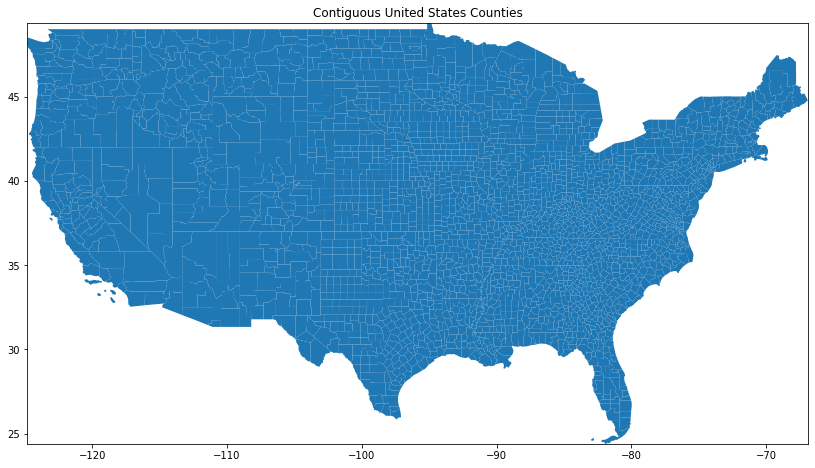

In [180]:
# Plot contiguous counties
fig, ax = plt.subplots(figsize=(14,12))
#fig.tight_layout()
ax.set(title='Contiguous United States Counties')
cont_usa.plot(ax=ax)

xlim = ([cont_usa.total_bounds[0],  cont_usa.total_bounds[2]])
ylim = ([cont_usa.total_bounds[1],  cont_usa.total_bounds[3]])

ax.set_xlim(xlim)
ax.set_ylim(ylim)

### 1.1.6 Save Datasets

In [ ]:
# Save df of USA hospitals to access in next step --> ../data/interim
# 1_1_usa_hosp


# Save df of US Census by county --> ../data/interim
# 1_1_usa_pop


# Save geodf of contiguous USA counties to access in next step --> ../data/interim
# 1_1_usa_counties_geo


# Save geodf of USA states to access in next step --> ../data/interim
# 1_1_usa_states_geo

